### Selecting columns, viualizing

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [2]:
data = pd.read_csv("data_clean.csv")

C:\Users\Balint\miniconda3\envs\d2l\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110155 entries, 0 to 110154
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       110155 non-null  object 
 1   titleType                    110155 non-null  object 
 2   primaryTitle                 110155 non-null  object 
 3   originalTitle                110155 non-null  object 
 4   isAdult                      110155 non-null  int64  
 5   startYear                    110155 non-null  object 
 6   endYear                      110155 non-null  object 
 7   runtimeMinutes               110155 non-null  object 
 8   genres                       110155 non-null  object 
 9   averageRating                110155 non-null  float64
 10  numVotes                     110155 non-null  int64  
 11  Budget                       26636 non-null   float64
 12  Gross US & Canada            18139 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on
data = data.drop(columns=["tconst", "titleType", "primaryTitle", "originalTitle", "endYear", "isAdult", "isAdult2", "Gross US & Canada"])  #, "Opening weekend US & Canada", ])
data = data.dropna()

52


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'Documentary', 'Mystery', 'Biography', 'Crime', 'Adventure', 'Action', 'Film-Noir', 'Animation', 'History', 'Comedy', 'Romance', 'Sport', 'News', 'Western', 'Fantasy', 'War', 'Music', 'Sci-Fi', 'Musical', 'Drama', 'Thriller', 'Horror', 'Family'}


In [6]:
for genre in genre_set:
    print(genre, end=" ")
    data[f"is{genre}"] = data.apply(lambda row: int(genre in row["genres"]), axis=1)

Documentary Mystery Biography Crime Adventure Action Film-Noir Animation History Comedy Romance Sport News Western Fantasy War Music Sci-Fi Musical Drama Thriller Horror Family 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "%")

Documentary 1.0155346639183551 %
Mystery 3.3482479513347743 %
Biography 2.810316223417626 %
Crime 7.4003318083555385 %
Adventure 6.887537077070031 %
Action 9.220250364486452 %
Film-Noir 0.02010959730531396 %
Animation 1.9053843446784977 %
History 1.3724800160876778 %
Comedy 15.343622743954551 %
Romance 7.078578251470515 %
Sport 0.9954250666130411 %
News 0.015082197978985471 %
Western 0.276506962948067 %
Fantasy 3.026494394449751 %
War 0.789301694233573 %
Music 1.8299733547835706 %
Sci-Fi 2.5891106530591723 %
Musical 0.45246593936956414 %
Drama 21.532351314664925 %
Thriller 5.887084611130662 %
Horror 3.956563269820522 %
Family 2.2472474988688353 %


In [8]:
# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        # print(row[column], end=" -> ")
        if "." in row[column]:
            # print(int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100)
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            # print(int(row[column][:-1]) * 1000)
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

# Just an example of problematic data types
# print("Problematic form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])

# print("Resolved form")
# print(data.startYear.unique())
# print(data.runtimeMinutes.unique())
# print(data["User reviews"].unique())
# print(data["Critic reviews"].unique())

In [13]:
print("All features present:")
filtered = data[["startYear", "Budget", "Gross worldwide"]].dropna()  # data.dropna()
print(len(filtered))
print()

All features present:
7896



In [14]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,Budget,Gross worldwide
startYear,1.000000,0.023486,-0.032499
Budget,0.023486,1.000000,0.609708
Gross worldwide,-0.032499,0.609708,1.000000


In [15]:
# fig, ax = plt.subplots()

# means = []
# for year in [2016, 2017, 2018, 2019, 2020, 2021]:
#     means.append(filtered[filtered.startYear == year]["Opening weekend US & Canada"].mean())

# ax.scatter([2016, 2017, 2018, 2019, 2020, 2021], means)

In [16]:
# H0: The distribution of the opening weekend incomes is the same for 2020 as for prev. years.
# fig, ax = plt.subplots()
# ax.hist(filtered[filtered.startYear == 2018]["Opening weekend US & Canada"], bins=30)

In [17]:
for year in range(2000, 2022):
    print(year, len(filtered[(filtered["startYear"] == year) & (filtered["Budget"] > filtered["Gross worldwide"])]) / len(filtered[filtered["startYear"] == year]))

2000 0.45410628019323673
2001 0.4681818181818182
2002 0.4496124031007752
2003 0.4034334763948498
2004 0.42911877394636017
2005 0.4432234432234432
2006 0.45317220543806647
2007 0.47435897435897434
2008 0.45302013422818793
2009 0.46258503401360546
2010 0.4028268551236749
2011 0.4139072847682119
2012 0.46875
2013 0.43666666666666665
2014 0.4218181818181818
2015 0.39097744360902253
2016 0.3435114503816794
2017 0.30985915492957744
2018 0.2932692307692308
2019 0.2484076433121019
2020 0.5882352941176471
2021 0.37777777777777777


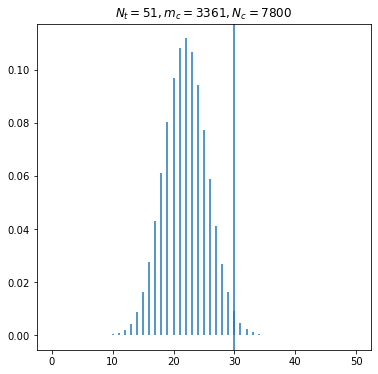

In [24]:
from scipy.stats import betabinom
# Bonferroni correction
n_1 = len(filtered[filtered["startYear"] == 2020])
m_0 = len(filtered[(filtered["startYear"] < 2020) & (filtered["Budget"] > filtered["Gross worldwide"])])
n_0 = len(filtered[filtered["startYear"] < 2020])
p = betabinom(n_1, m_0 + 1, n_0 - m_0 + 1)
p = betabinom(N_t, m_c + 1, N_c - m_c + 1)
          
mm_1 = np.arange(N_t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title(f"$N_t = {n_1}, m_c = {m_0}, N_c = {n_0}$")
ax.vlines(mm_1, 0, p.pmf(mm_1))
ax.axvline(len(filtered[(filtered["startYear"] == 2020) & (filtered["Budget"] > filtered["Gross worldwide"])]))
print(1 - betabinom.cdf(30 - 1, n_1, m_0 + 1, n_0 - m_0 + 1))

0.00014672769183932122


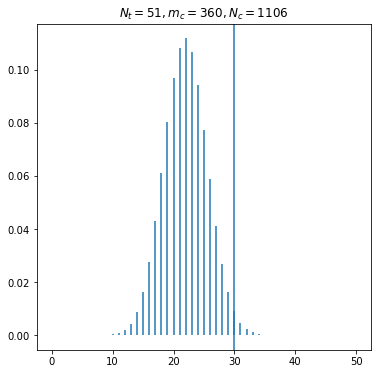

In [29]:
from scipy.stats import betabinom
# Bonferroni correction
n_1 = len(filtered[filtered["startYear"] == 2020])
m_0 = len(filtered[(filtered["startYear"].between(2015, 2019)) & (filtered["Budget"] > filtered["Gross worldwide"])])
n_0 = len(filtered[filtered["startYear"].between(2015, 2019)])
p = betabinom(n_1, m_0 + 1, n_0 - m_0 + 1)
p = betabinom(N_t, m_c + 1, N_c - m_c + 1)

mm_1 = np.arange(N_t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title(f"$N_t = {n_1}, m_c = {m_0}, N_c = {n_0}$")
ax.vlines(mm_1, 0, p.pmf(mm_1))
ax.axvline(len(filtered[(filtered["startYear"] == 2020) & (filtered["Budget"] > filtered["Gross worldwide"])]))
print(1 - betabinom.cdf(30 - 1, n_1, m_0 + 1, n_0 - m_0 + 1))

In [ ]:
from scipy.stats import betabinom
# Bonferroni correction
n_1 = len(filtered[filtered["startYear"] == 2020])
m_0 = len(filtered[(filtered["startYear"].between(2015, 2019)) & (filtered["Budget"] > filtered["Gross worldwide"])])
n_0 = len(filtered[filtered["startYear"].between(2015, 2019)])
p = betabinom(n_1, m_0 + 1, n_0 - m_0 + 1)
p = betabinom(N_t, m_c + 1, N_c - m_c + 1)

mm_1 = np.arange(N_t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title(f"$N_t = {n_1}, m_c = {m_0}, N_c = {n_0}$")
ax.vlines(mm_1, 0, p.pmf(mm_1))
ax.axvline(len(filtered[(filtered["startYear"] == 2020) & (filtered["Budget"] > filtered["Gross worldwide"])]))
print(1 - betabinom.cdf(30 - 1, n_1, m_0 + 1, n_0 - m_0 + 1))